In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset, Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_45916/1986613272.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-24 22:10:01.454885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [3]:
naive_LSTM = Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

2024-04-24 22:10:03.572880: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.001

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)

hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)


# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(hidden1)
model = Model(inputs=[input_layer], outputs=out)


model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
naive_LSTM.model.summary()

2024-04-24 22:10:04.073066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-24 22:10:04.075819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-24 22:10:04.077404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 LSTM1 (LSTM)                (None, 15, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 15, 100)           0         
                                                                 
 LSTM2 (LSTM)                (None, 15, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 15, 100)           0         
                                                                 
 LSTM3 (LSTM)                (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0   

2024-04-24 22:10:04.534496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-24 22:10:04.536181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-24 22:10:04.537363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [5]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])


Epoch 1/20


2024-04-24 22:10:04.993073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-24 22:10:04.996203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-24 22:10:04.998483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 0.0209 - mean_squared_error: 0.0209

2024-04-24 22:10:12.103289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-24 22:10:12.105803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-24 22:10:12.107335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 9s 370ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0497 - val_mean_squared_error: 0.0497
Epoch 2/20
9/9 [==============================] - 2s 176ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/20
9/9 [==============================] - 1s 150ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 4/20
9/9 [==============================] - 1s 163ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 5/20
9/9 [==============================] - 2s 225ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 6/20
9/9 [==============================] - 2s 209ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 7/20
9/9 [==============================] - 2

In [6]:
my_portfolio = Portfolio(origination_date=(val_idx[0] - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(val_idx[0] - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(val_idx[0] - tmpdelta(days=1)),
                                note = 'Initial deposit' )

ref_portfolio = Portfolio(origination_date=(val_idx[0] - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(val_idx[0] - tmpdelta(days=1)))
ref_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(val_idx[0] - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [7]:
#pred_df = naive_LSTM.predict_batch(data_to_process = BTC.history['close'].loc[val_idx[0]-tmpdelta(days=14):])

In [37]:


def execute_suggestions(suggestions, portfolio):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today,
                                    note =  suggestions['note'].loc[ticker])

pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))

for x in range (naive_LSTM.input_span, len(val_idx)-1):
    data_for_today = BTC.history['close'].\
                        loc[val_idx[x]-tmpdelta(days=(naive_LSTM.input_span-1)):val_idx[x]]
    new_pred = naive_LSTM.predict_one(data_for_today)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(val_idx[x-1], my_portfolio)
    execute_suggestions(suggestion, my_portfolio)

my_portfolio.update_value(up_to=pred_df.index[-1])
ref_portfolio.update_value(up_to=pred_df.index[-1])

for 2023-08-14 20:00:00 predicted 32014.216796875
today: 2023-08-13 20:00:00 BTC is 29405.49
for 2023-08-15 20:00:00 predicted 32026.798828125
today: 2023-08-14 20:00:00 BTC is 29170.14
for 2023-08-16 20:00:00 predicted 32004.515625
today: 2023-08-15 20:00:00 BTC is 28700.51
for 2023-08-17 20:00:00 predicted 31991.85546875
today: 2023-08-16 20:00:00 BTC is 26627.57
for 2023-08-18 20:00:00 predicted 31938.33203125
today: 2023-08-17 20:00:00 BTC is 26048.89
for 2023-08-19 20:00:00 predicted 31845.173828125
today: 2023-08-18 20:00:00 BTC is 26096.42
for 2023-08-20 20:00:00 predicted 31708.9375
today: 2023-08-19 20:00:00 BTC is 26189.14
for 2023-08-21 20:00:00 predicted 31532.55078125
today: 2023-08-20 20:00:00 BTC is 26125.18
for 2023-08-22 20:00:00 predicted 31313.287109375
today: 2023-08-21 20:00:00 BTC is 26042.11
for 2023-08-23 20:00:00 predicted 31035.259765625
today: 2023-08-22 20:00:00 BTC is 26427.54
for 2023-08-24 20:00:00 predicted 30758.12890625
today: 2023-08-23 20:00:00 BTC i

KeyboardInterrupt: 

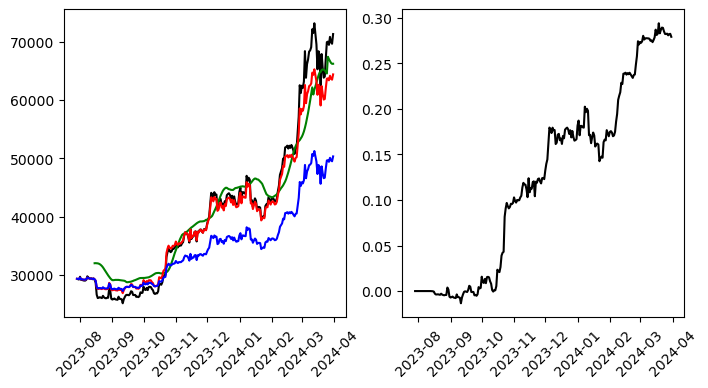

In [22]:
# Plot the results
fig, ax = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)
actual_df = BTC.history.loc[val_idx]
ax[0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
ax[0].plot(pred_df.index, pred_df['Predicted price'], color = 'green', label = 'Predicted')
ax[0].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experimental Portfolio')
ax[0].plot(ref_portfolio.value.index, ref_portfolio.value['value'], color = 'blue', label = 'Reference Portfolio')
for tick in ax[0].get_xticklabels():
        tick.set_rotation(45)

ax[1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - ref_portfolio.value['value'])/ref_portfolio.value['value'], color = 'black', label = 'ROI')
for tick in ax[1].get_xticklabels():
        tick.set_rotation(45)

In [21]:
pred_df

,Predicted price
date_time,
2023-08-14 20:00:00,32014.216797
2023-08-15 20:00:00,32026.798828
2023-08-16 20:00:00,32004.515625
2023-08-17 20:00:00,31991.855469
2023-08-18 20:00:00,31938.332031
...,...
2024-03-26 20:00:00,66987.101562
2024-03-27 20:00:00,66672.289062
2024-03-28 20:00:00,66339.312500
